# Intro to neural networks

### - Section 1: Single Layer Perceptron
### - Section 2: Multi Layer Perceptron
### - Section 3: Convolutional Neural Network
### - Section 4: Flexible NN (CNN + MLP)
### - Section 5: Multi Task Learning
### - Section 6: Denoising Auto Encoder
### - Section 7: Variational Auto Encoder
### - Section 8: Bayesian Neural Network

In [1]:
import warnings
import time
import tensorflow.compat.v1 as tf
import numpy                as np
import matplotlib.pyplot    as plt
import os
from IPython.display        import Image
from scipy                  import stats 
from sklearn.decomposition  import PCA
from tqdm                   import tqdm_notebook as tqdm
from tensorflow             import keras

tf.disable_eager_execution()
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

### All code has been implemented personally in tensorflow and the classes used can be found in the ML_implementations repo.

In [3]:
from ML_implementations.neuralnets import *

### Data Import - MNIST Numbers

The first data set we will work on will be the MNIST numbers dataset of handwritten digits from 0-9. We will be classifying these images to the corresponding digit classes.

In [4]:
mnist   = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test  = x_test.shape[0]

x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1 ### Preprocessing

nb_features = np.prod(x_train.shape[1:])
x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

For example, we can visualise the first 4 exemplars:

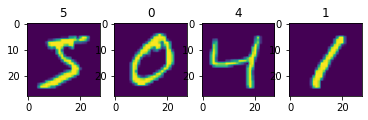

In [5]:
plt.subplot(1,4,1)
plt.imshow(x_train[0,:].reshape(28,28))
plt.title('5')
plt.subplot(1,4,2)
plt.imshow(x_train[1,:].reshape(28,28))
plt.title('0')
plt.subplot(1,4,3)
plt.imshow(x_train[2,:].reshape(28,28))
plt.title('4')
plt.subplot(1,4,4)
plt.imshow(x_train[3,:].reshape(28,28))
plt.title('1')
plt.show()

## Section 1: Single Layer Perceptron

We will start off by attempting to classify between the digits 0 and 1. We will filter our data to these two classes, setting the 0 class to be -1 and the 1 class to be 1.

In [9]:
dig1 = 0
dig2 = 1

cond = (y_train == dig1) + (y_train == dig2)
binary_x_train = x_train[cond,:]
binary_y_train = y_train[cond]*1.

binary_y_train[binary_y_train == dig1] = -1
binary_y_train[binary_y_train == dig2] = 1

cond1 = (y_test == dig1) + (y_test == dig2)
binary_x_test = x_test[cond1,:]
binary_y_test = y_test[cond1]*1.
binary_y_test[binary_y_test == dig1] = -1
binary_y_test[binary_y_test == dig2] = 1

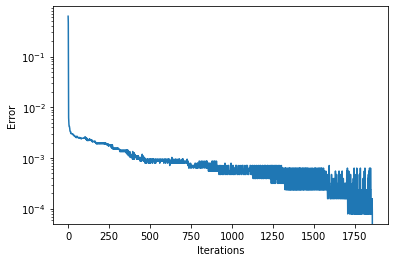

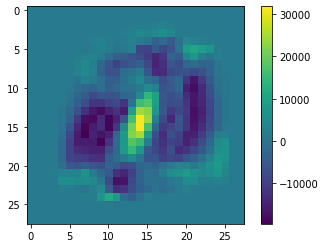

In [10]:
slp = SLP(binary_x_train, binary_y_train, iterations=2000)
weights, bias = slp.optimise()
slp.plot_errors()
slp.visualise(weights.reshape(28,28))

We can see that the perceptron has learned to weight pixels in the center (corresponding to the stem of the 1) positively, and pixels that form the ring of the 0 negatively.

## Section 2: Multi Layer Perceptron

Now we can extend the SLP to a multi layer perceptron and attempt to classify all the images into the corresponding 10 classes. First we need to one hot encode the labels:

In [5]:
y_train = np.eye(10)[y_train]
y_test  = np.eye(10)[y_test]

In [6]:
y_train.shape

(60000, 10)

In [7]:
x_train.shape

(60000, 784)

We achieve a high level of accuracy with a fairly simple MLP of 2 hidden layers, of 1000 neurons each using ReLu activation and softmax on the logits.

In [8]:
mlp   = MLP()
sess  = mlp.train(x_train[:30000,:],y_train[:30000,:])
preds = mlp.test(x_test)
sess  = mlp.train(x_train[30000:,:],y_train[30000:,:])
preds1 = mlp.test(x_test)
acc   = mlp.calc_accuracy(preds, y_test)
acc1   = mlp.calc_accuracy(preds1, y_test)
sess.close()

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


TypeError: __init__() got an unexpected keyword argument 'reuse'

## Section 3: Convolutional Neural Network

Relaxing the assumption that each feature is independent, we can leverage dependencies between fetaures using convolutions. For example, in the image of a face, skin pixels will likely be next to other skin pixels, and this dependency can be used to improve accuracy and training time.

We implement a CNN with convolutions of size (4,4), stride of 2 and padding, with pooling layers in between. 3 convolutional layers of depth 32,64 and 128 neurons. Again ReLU has been used, with softmax on the logits.

In [10]:
cnn   = CNN()
sess  = cnn.train(x_train,y_train)
preds = cnn.test(x_test)
acc   = cnn.calc_accuracy(preds, y_test)
sess.close()

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.Flatten instead.


Test accuracy achieved: 0.990


## Section 4: CNN + MLP

This NN class is more flexible than the previous two and can be used to combine convolutional layers with dense layers. We implement this model on the MNIST fashion data. We will implement this to classify clothing items into 10 classes of type (t-shirt, shoes etc) and 3 classes of style (unisex, non-unisex etc). We will do this separately at first, so we will use to independent networks.

We import the data:

In [4]:
"""
Code for loading the dataset
"""
import tensorflow.keras.datasets.fashion_mnist as fashion_mnist
from tensorflow.keras.utils import to_categorical

def load_data(): 

    (train_X, train_y_1), (test_X, test_y_1) = fashion_mnist.load_data()
    n_class_1 = 10
    train_y_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in train_y_1)  
    test_y_2  = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in test_y_1)
    n_class_2 = 3
    train_X   = np.expand_dims(train_X, axis=3)
    test_X    = np.expand_dims(test_X, axis=3)
    train_y_1 = to_categorical(train_y_1, n_class_1)
    test_y_1  = to_categorical(test_y_1, n_class_1)
    train_y_2 = to_categorical(train_y_2, n_class_2)
    test_y_2  = to_categorical(test_y_2, n_class_2)
    
    return train_X, train_y_1, train_y_2, test_X, test_y_1, test_y_2

x_train, y_train_1, y_train_2, x_test, y_test_1, y_test_2 = load_data()

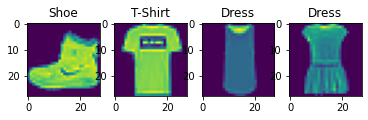

In [5]:
plt.subplot(1,4,1)
plt.imshow(x_train[0,:].reshape(28,28))
plt.title('Shoe')
plt.subplot(1,4,2)
plt.imshow(x_train[1,:].reshape(28,28))
plt.title('T-Shirt')
plt.subplot(1,4,3)
plt.imshow(x_train[2,:].reshape(28,28))
plt.title('Dress')
plt.subplot(1,4,4)
plt.imshow(x_train[3,:].reshape(28,28))
plt.title('Dress')
plt.show()

These two networks have the same structure, with the exception of different sized logit layers at the end, reflecting the differently sized classes. This structure is 3 convolutional layers of depth 32,64 and 128 with pooling, convolutions of size (3,3) and strides of 2 with padding. This is followed by a dense layer of 3136 neurons, then two further dense layers of 1024 and 100 neurons respectively.

In [13]:
nn1    = NN(structure1 = [32,64,128,3136,1024,100], 
            structure2 = ['conv','conv','conv','dense', 'dense', 'dense'],
            strides    = [1,2,2,None,None,None])
sess   = nn1.train(x_train,y_train_1)
preds  = nn1.test(x_test)
acc    = nn1.calc_accuracy(preds, y_test_1)
sess.close()

Test accuracy achieved: 0.905


In [32]:
nn2    = NN(structure1 = [32,64,128,3136,1024,100], 
            structure2 = ['conv','conv','conv','dense', 'dense', 'dense'],
            strides    = [1,2,2,None,None,None],
            labels     = 3)
sess  = nn2.train(x_train,y_train_2)
preds = nn2.test(x_test)
acc   = nn2.calc_accuracy(preds, y_test_2)
sess.close()

Test accuracy achieved: 0.400


## Section 5: Multi Task Learning

Instead of treating the two classification tasks independently as in section 4, we can train them together intitalliy and optimise a joint loss. Here we train with the same convolutional layers as above, and the dense layer of 3136 neurons however after this layer we diverge trainign into two separate sets of layers.

In [6]:
mtl  = MTL(x_train, y_train_1, y_train_2)
sess = mtl.train(x_train, y_train_1, y_train_2)
pred1, pred2 = mtl.test_MTL(x_test)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.


In [7]:
mtl.calc_accuracy(pred1,pred2,y_test_1, y_test_2)
sess.close()

Test accuracy achieved: 0.9004, 0.9417


## Section 6: Denoising Auto Encoder

In [15]:
mnist   = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test  = x_test.shape[0]

x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1 ### Preprocessing

nb_features = np.prod(x_train.shape[1:])
x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

Returning to the MNIST numbers data we can examine additional uses of neural networks. The ones we have used so far have been for classification, however we can also formulate them as regression problems. A DAE is an unsupervised network that can be used to remove noise from images.

We start of by training with a nmber of noisy versions of each handwritten digit. We then ask the network to predict what a nosiy version should look like, with it hopefully removing the artifical noise we have added in. In practice this happens by the encoder part compressing the image down to a low dimensional latent space which is then taken by the decoder and blown back up to full size.

In [16]:
dae  = DAE()
sess = dae.train(x_train)

We can calculate the MSE between the orginal and denoised test images after various levels of noise have been added. I have chosen to take the mean of the MSE over each test image with 5 different levels of noise injected:

In [17]:
error = dae.calc_accuracy(x_test, 1)
print(error)

0.034639116167943095


Note that this error is in our preprocessed space. The MSE over the orginal data is:
    

In [18]:
print(error * 127.5**2)

563.1021322051249


We can visualise the denoiser as follows:

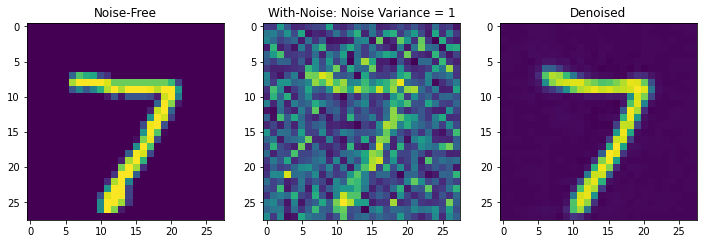

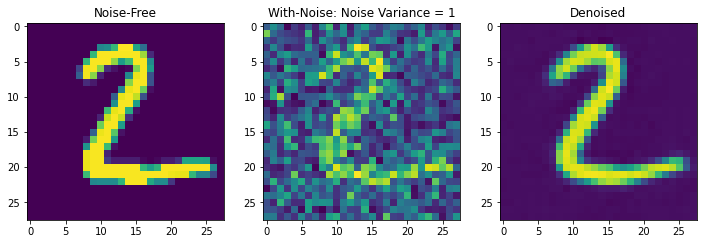

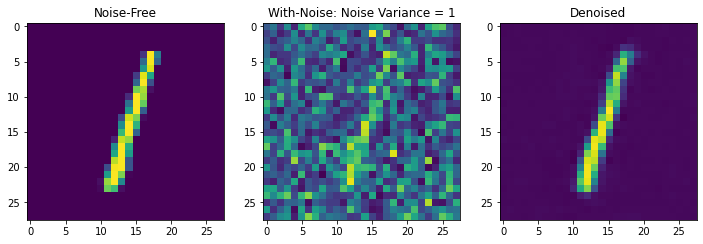

In [19]:
dae.visualise(x_test[0]);
dae.visualise(x_test[1]);
dae.visualise(x_test[2])

In [20]:
sess.close()

## Section 7: Variational Auto Encoder

A second application is the variational auto encoder. In this network the encoder reduces the image to a latent space over which we assume some distribution. We will assume a 2 dimesnional latent space over a Gaussian distribution. Once the model has been trained, we can sample in this latent space and pass this sample to the decoder, which will produce artifical variations of the original image. Similarity to the original will be determined by how close to the mean of the distribution we sample.

In [21]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

image_size       = x_train.shape[1]
original_dim     = image_size * image_size
x_train          = np.reshape(x_train, [-1, original_dim])
x_test           = np.reshape(x_test, [-1, original_dim])
x_train          = x_train.astype('float32') / 255
x_test           = x_test.astype('float32') / 255

We train the model:

In [22]:
vae  = VAE()
sess = vae.train(x_train)

We can visualise the learnt manifold and the corresponding images:

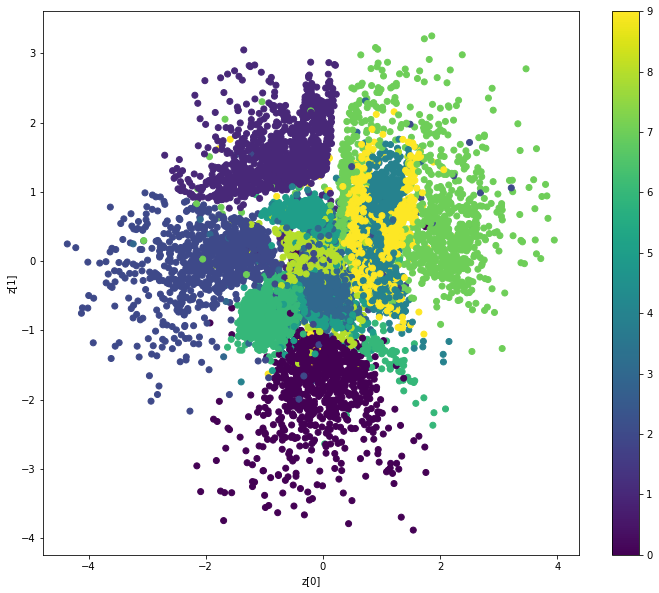

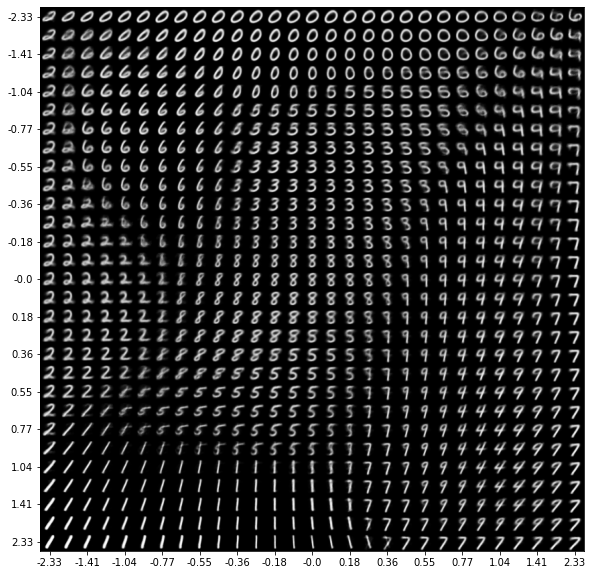

In [23]:
vae.visualise_manifold(x_test,y_test)

To generate new digits we simply sample in the latent space:

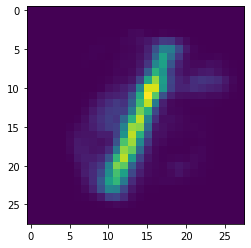

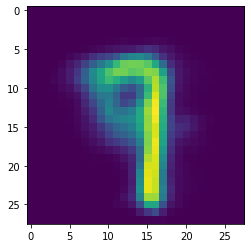

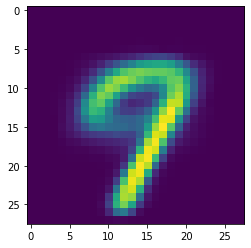

In [24]:
vae.visualise_image();
vae.visualise_image();
vae.visualise_image();

In [25]:
sess.close()

## Section 8: Bayesian Neural Network

In [4]:
mnist   = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test  = x_test.shape[0]

x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1 ### Preprocessing

nb_features = np.prod(x_train.shape[1:])
x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

In [8]:
x_train.shape

(60000, 28, 28, 1)

We can extend the standard neural network architecture to a Bayesian framewrok where we introduce priors (Gaussian) on the node weights and determine the posterior of these weights.

This will help reduce the problem of overfitting, for which NNs are notably susceptible.

In [6]:
bnn  = BNN()
sess = bnn.train(x_train, y_train)

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


KeyboardInterrupt: 

In [28]:
preds = bnn.test(x_test)
acc   = bnn.calc_accuracy(preds,y_test)

Test accuracy achieved: 0.977


We can visualise the posterior means and stds over iterations as the posterior is updated:

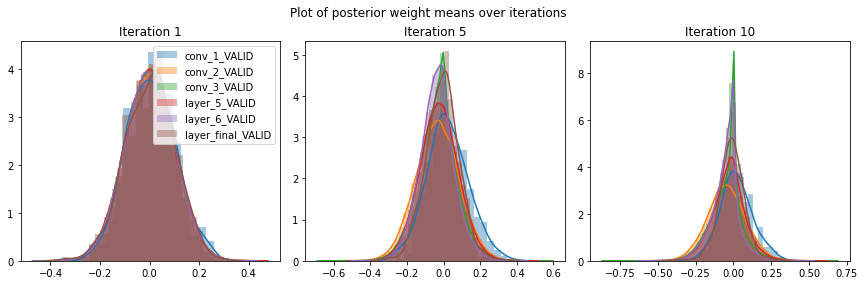

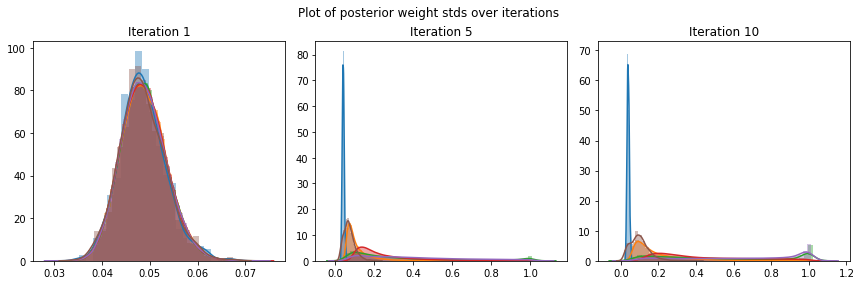

In [29]:
bnn.plot_posterior()

And we can see use monte carlo sampling to sample from the joint posterior, allowing us to view the uncertainity regarding our predictions:

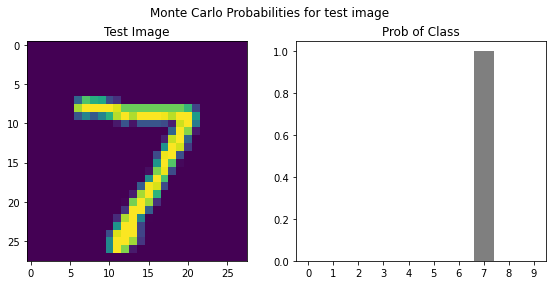

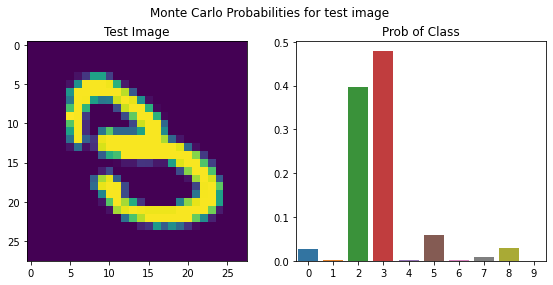

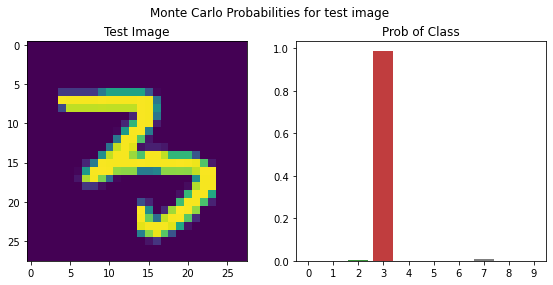

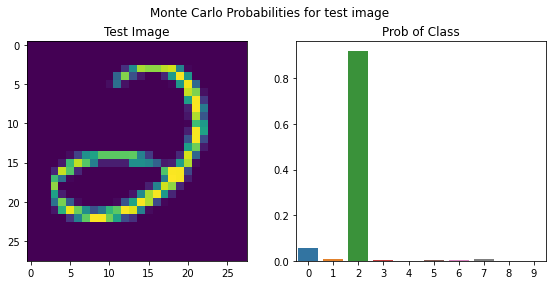

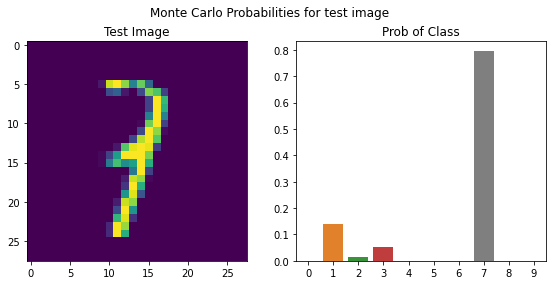

In [30]:
test_pred = bnn.sample_predictions(x_test[0,:,:,:], 1000);
bnn.sample_predictions(x_test[18,:,:,:], 1000);
bnn.sample_predictions(x_test[2300,:,:,:], 1000);
bnn.sample_predictions(x_test[1050,:,:,:], 1000);
bnn.sample_predictions(x_test[1500,:,:,:], 1000);